In [17]:
#%% -------- 1. Imports & Configuration --------
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import tensorflow as tf
from random import sample
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [18]:
# Configuration
TARGET_SIZE = (650, 325)  # Reduced size for faster processing
DATA_PATHS = {
    'train': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train",
    'valid': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val",
    'test': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"
}

In [19]:
#%% -------- 2. Metaheuristic Optimizers --------
class PSOOptimizer:
    def __init__(self, n_particles=10, iterations=5, param_bounds=None):
        self.n_particles = n_particles
        self.iterations = iterations
        self.param_bounds = param_bounds or {
            'learning_rate': (1e-5, 1e-3),
            'filters1': (16, 64),
            'filters2': (16, 64),
            'dense_units': (32, 128),
            'dropout': (0.1, 0.5)
        }
        self.best_params = None
        
    def optimize(self, X_train, y_train, X_val, y_val):
        particles = self._initialize_particles()
        velocities = np.zeros_like(particles)
        pbest = particles.copy()
        pbest_scores = np.zeros(self.n_particles)
        gbest = None
        gbest_score = -np.inf
        
        # Initial evaluation
        for i in range(self.n_particles):
            score = self._evaluate_particle(particles[i], X_train, y_train, X_val, y_val)
            pbest_scores[i] = score
            if score > gbest_score:
                gbest_score = score
                gbest = particles[i].copy()
                
        # Optimization loop
        for _ in range(self.iterations):
            for i in range(self.n_particles):
                # Update velocity and position
                r1, r2 = np.random.rand(2)
                velocities[i] += 0.5*r1*(pbest[i] - particles[i]) + \
                               0.5*r2*(gbest - particles[i])
                particles[i] = np.clip(particles[i] + velocities[i], 0, 1)
                
                # Evaluate new position
                score = self._evaluate_particle(particles[i], X_train, y_train, X_val, y_val)
                if score > pbest_scores[i]:
                    pbest_scores[i] = score
                    pbest[i] = particles[i].copy()
                    if score > gbest_score:
                        gbest_score = score
                        gbest = particles[i].copy()
                        
        self.best_params = self._decode_particle(gbest)
        return self.best_params
    
    def _initialize_particles(self):
        return np.random.rand(self.n_particles, len(self.param_bounds))
    
    def _decode_particle(self, particle):
        decoded = {}
        for i, (key, (min_val, max_val)) in enumerate(self.param_bounds.items()):
            if key in ['filters1', 'filters2', 'dense_units']:
                decoded[key] = int(min_val + particle[i] * (max_val - min_val))
            else:
                decoded[key] = min_val + particle[i] * (max_val - min_val)
        return decoded
    
    def _evaluate_particle(self, particle, X_train, y_train, X_val, y_val):
        params = self._decode_particle(particle)
        model = self._create_model(params)
        model.fit(X_train, y_train, epochs=2, batch_size=16, verbose=0)
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        return accuracy
    
    def _create_model(self, params):
        model = Sequential([
            Conv2D(params['filters1'], (3,3), activation='relu', input_shape=(*TARGET_SIZE, 1)),
            MaxPooling2D(2,2),
            Conv2D(params['filters2'], (3,3), activation='relu'),
            MaxPooling2D(2,2),
            GlobalAveragePooling2D(),
            Dense(params['dense_units'], activation='relu'),
            Dropout(params['dropout']),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=optimizers.Adam(learning_rate=params['learning_rate']),
                     loss='binary_crossentropy', metrics=['accuracy'])
        return model

In [20]:
#%% -------- 3. Data Loading & Preprocessing --------
def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    for label in ['female', 'male']:
        label_path = os.path.join(directory, label)
        for image_file in os.listdir(label_path):
            image = cv2.imread(os.path.join(label_path, image_file), cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image = cv2.resize(image, target_size)
                images.append(image.reshape(*target_size, 1))
                labels.append(label)
    return np.array(images)/255.0, np.array(labels)

# Load datasets
train_images, train_labels = load_images_from_directory(DATA_PATHS['train'], TARGET_SIZE)
valid_images, valid_labels = load_images_from_directory(DATA_PATHS['valid'], TARGET_SIZE)
test_images, test_labels = load_images_from_directory(DATA_PATHS['test'], TARGET_SIZE)

# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
valid_labels = le.transform(valid_labels)
test_labels = le.transform(test_labels)

In [21]:
#%% -------- 4. Hyperparameter Optimization --------
# Initialize and run PSO
pso_optimizer = PSOOptimizer(n_particles=5, iterations=3)
best_params = pso_optimizer.optimize(train_images[:100], train_labels[:100], 
                                   valid_images[:50], valid_labels[:50])
print("Optimized Parameters:", best_params)

Optimized Parameters: {'learning_rate': 0.000961690037289512, 'filters1': 27, 'filters2': 63, 'dense_units': 99, 'dropout': 0.4602471739771399}


In [22]:
#%% -------- 5. Model Training with Optimized Parameters --------
def create_final_model(params):
    model = Sequential([
        Conv2D(params['filters1'], (3,3), activation='relu', input_shape=(*TARGET_SIZE, 1)),
        MaxPooling2D(2,2),
        Conv2D(params['filters2'], (3,3), activation='relu'),
        MaxPooling2D(2,2),
        GlobalAveragePooling2D(),
        Dense(params['dense_units'], activation='relu'),
        Dropout(params['dropout']),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=params['learning_rate']),
                 loss='binary_crossentropy', metrics=['accuracy'])
    return model

final_model = create_final_model(best_params)
history = final_model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15)]
)

Epoch 1/50
22/22 [==============================] - 86s 4s/step - loss: 0.6820 - accuracy: 0.5175 - val_loss: 0.6752 - val_accuracy: 0.5510
Epoch 2/50
22/22 [==============================] - 84s 4s/step - loss: 0.6606 - accuracy: 0.6297 - val_loss: 0.6427 - val_accuracy: 0.6020
Epoch 3/50
22/22 [==============================] - 84s 4s/step - loss: 0.6159 - accuracy: 0.7216 - val_loss: 0.5852 - val_accuracy: 0.6531
Epoch 4/50
22/22 [==============================] - 83s 4s/step - loss: 0.5481 - accuracy: 0.7332 - val_loss: 0.4898 - val_accuracy: 0.8112
Epoch 5/50
22/22 [==============================] - 84s 4s/step - loss: 0.4804 - accuracy: 0.7726 - val_loss: 0.5018 - val_accuracy: 0.7041
Epoch 6/50
22/22 [==============================] - 83s 4s/step - loss: 0.4259 - accuracy: 0.7915 - val_loss: 0.4497 - val_accuracy: 0.7653
Epoch 7/50
22/22 [==============================] - 84s 4s/step - loss: 0.4000 - accuracy: 0.7988 - val_loss: 0.3690 - val_accuracy: 0.7806
Epoch 8/50
22/22 [==

4/4 [==============================] - 2s 498ms/step - loss: 0.3621 - accuracy: 0.8454

Test Accuracy: 84.54%
4/4 [==============================] - 2s 472ms/step

Classification Report:
              precision    recall  f1-score   support

      Female       1.00      0.69      0.82        49
        Male       0.76      1.00      0.86        48

    accuracy                           0.85        97
   macro avg       0.88      0.85      0.84        97
weighted avg       0.88      0.85      0.84        97



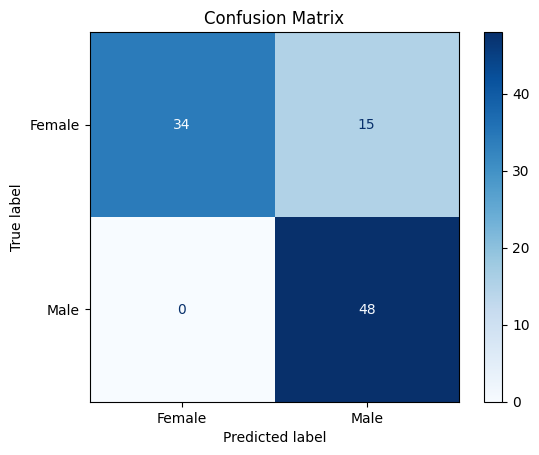

In [25]:
#%% -------- 6. Model Evaluation --------
test_loss, test_acc = final_model.evaluate(test_images, test_labels)
print(f"\nTest Accuracy: {test_acc:.2%}")

# Classification Report
y_pred = (final_model.predict(test_images) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=['Female', 'Male']))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [26]:
#%% -------- 7. Model Saving & Inference --------
final_model.save('optimized_gender_model.keras')

def predict_gender(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, TARGET_SIZE).reshape(1, *TARGET_SIZE, 1)/255.0
    prediction = final_model.predict(img)[0][0]
    return 'Male' if prediction > 0.5 else 'Female'

# Example usage
test_image = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test\\male\\male.441.JPG"
print(f"Predicted Gender: {predict_gender(test_image)}")

1/1 [==============================] - 0s 47ms/step
Predicted Gender: Male
